In [17]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='448216e6-8edf-4667-a9bd-c70acd8b95c7', project_access_token='p-626c5b7bb5bbbb567b30200f0040fd73149ebff6')


<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

# Monitor WML Model With Watson OpenScale

### Contents
- [Set up Project Token and API Key](#tokens)
- [Introduction](#intro)
- [Setup](#setup)
- [Fetch Model and Deployments](#model)
- [Configure OpenScale](#openscale)
- [Create Service Provider and Subscription](#subscription)
- [Quality monitor](#quality)
- [Fairness monitor](#fairness)
- [Explanations](#explain)

### Set up Project Token and API Key  <a name="tokens"></a>
Before executing this notebook, you need to insert a project token and an IBM Cloud API key:<br>

#### Provide the project access token
1. When you imported the project from the Gallery, the first cell of this notebook should contain the project access token. 

2. If this notebook does not contain a first cell with a project access token, then to generate the token, click **More > Insert project token** on the menu bar.<br>

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)



#### Provide your IBM Cloud API key
1. Generate an IBM Cloud API key on the [API Keys page in the IBM Cloud console](https://cloud.ibm.com/iam/apikeys).
2. Click **Create an IBM Cloud API key**. Provide a key name, and click **Create**, then copy the created key and paste it below. As a best practice, download the API key in addition to copying the key. 


In [18]:
ibmcloud_api_key = '2BDXSVijZILATG_DiUWIpxrAnooB7b6ejiysXxs5orzv'

You can then step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.<br>

## Introduction<a name="intro"></a>
In **1-model-training-with-factsheets** notebook, you trained our Mortgage Approval Prediction Model and deployed it using WML. In this notebook, you will programmatically set up and configure OpenScale, create a data mart for the model with Watson OpenScale and configure OpenScale to monitor that deployment, and inject records and measurements for viewing in the OpenScale insights dashboard. Access to a relational database is required to monitor the model with openscale, the notebook by default uses the postgres internal db.


## Setup <a name="setup"></a>

In the cells below, you install/import the python libraries that you will use throughout the notebook.`ibm_watson_openscale` is a python library that allows to work with [Watson OpenScale services](http://ai-openscale-python-client.mybluemix.net/) on IBM Cloud Pak for Data. 
 

In [19]:
import os
import datetime
import base64
import json
import requests
import time 

from ibm_watson_machine_learning import APIClient
import pandas as pd

import ibm_db, ibm_db_dbi as dbi

If you are not using latest version of the watson openscale library, use the below cells to upgrade.

In [20]:
!pip install --upgrade ibm-watson-machine-learning --user | tail -n 1
!pip install --upgrade ibm-watson-openscale --no-cache | tail -n 1

### User Inputs
#### 1. WOS Credentials
Below cell uses ibm cloud api key to authenticate to Watson Openscale.

In [21]:
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator,BearerTokenAuthenticator

from ibm_watson_openscale import *
from ibm_watson_openscale.supporting_classes.enums import *
from ibm_watson_openscale.supporting_classes import *


authenticator = IAMAuthenticator(apikey=ibmcloud_api_key)
wos_client = APIClient(authenticator=authenticator)


This tutorial can use Databases for PostgreSQL, Db2 Warehouse, or a free internal verison of PostgreSQL to create a datamart for OpenScale.

If you do not have a paid Cloud account or would prefer not to provision this paid service, you may use the free internal PostgreSQL service with OpenScale. Do not update the cell below.

If you previously configured OpenScale to use the free internal version of PostgreSQL, you can switch to a new datamart using a paid database service. If you would like to delete the internal PostgreSQL configuration and create a new one using service credentials supplied in the cell above, set the KEEP_MY_INTERNAL_POSTGRES variable below to False below. In this case, the notebook will remove your existing internal PostgreSQL datamart and create a new one with the supplied credentials. NO DATA MIGRATION WILL OCCUR.

In [22]:
KEEP_MY_INTERNAL_POSTGRES = True

In [23]:
DB_CREDENTIALS = None
SCHEMA_NAME = None

#### 2. Database Credentials

Database conncection details are stored in project data asset. Below cell fetches the connection using `project_lib` library.

In [24]:
DATABASE_CREDENTIALS=project.get_connection(name="Data Fabric Trial - Db2 Warehouse")

In [25]:
SCHEMA_NAME ="AI_MORTGAGE"
table_name = "MORTGAGE_SAMPLE_SCORING"


#### 3. Model and Deployment
Enter the details of the models deployed in the **1-model-training-with-factsheets** notebook in the below cell.

In [26]:
# Specify a name for the space being created, the saved model and the model deployment
space_name = 'Golden Bank Trends Preproduction Space'
model_name = 'Mortgage Approval Prediction Model'
deployment_name = 'Mortgage Approval Model Deployment'


Apart from these inputs, the following details can also be updated while running the notebook.

1. Columns used in the model and the target column details in [Create Subscription](#subscription) section.
2. Favourable class, unfavourable class, features to monitor bias for, majority and minority columns for bias in [Fairness monitor](#fairness) section .

## Fetch Model and Deployments <a name="model"></a>
Fetch the deployment space and model deployment from above specifications and assign the default space.

In [27]:
from ibm_watson_machine_learning import APIClient

location = os.environ['RUNTIME_ENV_REGION'] 
wml_credentials = {
    "apikey": ibmcloud_api_key,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}
wml_client = APIClient(wml_credentials)


l_space_details = []
l_space_details_created_times = []
for space_details in wml_client.spaces.get_details()['resources']:
    if space_details['entity']['name'] == space_name:
        space_id=space_details['metadata']['id']

try:
    
    # set this space as default space
    wml_client.set.default_space(space_id)
    print(space_name,"is set as default")
except:
    space_error=space_name+" not found"
    raise NameError(space_error)
    

Golden Bank Trends Preproduction Space is set as default


Get the deployment id and model id for the model in the current space.

In [28]:
l_deployment_details = []
l_deployment_details_created_times = []

for deployment in wml_client.deployments.get_details()['resources']:
        if deployment['entity']['name'] == deployment_name:            
                l_deployment_details.append(deployment)
                l_deployment_details_created_times.append(datetime.datetime.strptime(deployment['metadata']['created_at'],  '%Y-%m-%dT%H:%M:%S.%fZ'))
                

# get the index of the latest created date from the list and use that to get the deployment_id
list_latest_index = l_deployment_details_created_times.index(max(l_deployment_details_created_times))
deployment_uid = l_deployment_details[list_latest_index]['metadata']['id']
#fields=wml_client.deployments.get_details(deployment_uid)['entity']['custom']['fields']
#categorical_cols=wml_client.deployments.get_details(deployment_uid)['entity']['custom']['categorical_cols']
fields=['INCOME','YRS_AT_CURRENT_ADDRESS','YRS_WITH_CURRENT_EMPLOYER','NUMBER_OF_CARDS','CREDITCARD_DEBT','LOAN_AMOUNT','CREDIT_SCORE','PROPERTY_VALUE','AREA_AVG_PRICE','GENDER','EDUCATION','EMPLOYMENT_STATUS','MARITAL_STATUS','APPLIEDONLINE','RESIDENCE','COMMERCIAL_CLIENT','COMM_FRAUD_INV','LOANS']
categorical_cols=['GENDER','EDUCATION','EMPLOYMENT_STATUS','MARITAL_STATUS','APPLIEDONLINE','RESIDENCE','COMMERCIAL_CLIENT','COMM_FRAUD_INV']

model_uid=wml_client.deployments.get_details(deployment_uid)['entity']['asset']['id']
print("Deployment id for",deployment_name,":",deployment_uid)


Deployment id for Mortgage Approval Model Deployment : 8a8d342f-7d41-470d-b25f-e16222c6128d


The data that used to train the model is stored in a connection mentioned above. Below cells read the data into a pandas dataframe. This table will be used as a `training_data_reference` through out the notebook.

In [29]:


db2_warehouse_datafabric_trial_dsn = 'DATABASE={};HOSTNAME={};PORT={};PROTOCOL=TCPIP;UID={uid};PWD={pwd};SECURITY=SSL'.format(DATABASE_CREDENTIALS['database'],DATABASE_CREDENTIALS['host'],DATABASE_CREDENTIALS['port'],uid=DATABASE_CREDENTIALS['username'],pwd=DATABASE_CREDENTIALS['password'])

db2_warehouse_datafabric_trial_connection = dbi.connect(db2_warehouse_datafabric_trial_dsn)
   

In [30]:
sql_query='select * from AI_MORTGAGE.Mortgage_Approval_view'


pd_data = pd.read_sql_query(sql_query, con=db2_warehouse_datafabric_trial_connection)

pd_data.head()



,ID,NAME,STREET_ADDRESS,CITY,STATE,STATE_CODE,ZIP_CODE,EMAIL_ADDRESS,PHONE_NUMBER,GENDER,...,NUMBER_OF_CARDS,CREDITCARD_DEBT,LOANS,LOAN_AMOUNT,CREDIT_SCORE,COMMERCIAL_CLIENT,COMM_FRAUD_INV,PROPERTY_VALUE,AREA_AVG_PRICE,MORTGAGE_APPROVAL
0,110424,Adah Marks,4355-5 Pelham South,Park Ridge,Illinois,IL,41227,Adah.Marks@donny.ca,206-220-3128,Male,...,2,1168.0,1,7478.0,547,FALSE,FALSE,548618.0,NaN,0
1,110425,Jerrell Eichmann,5642-1 Hwy 78 East,Reston,Virginia,VA,41198,Jerrell.Eichmann@trycia.biz,972-510-7295,Male,...,2,1167.0,1,7476.0,547,TRUE,FALSE,548638.0,NaN,0
2,110426,Glennie Barrows,6736-1 Whitfield Ave,Houston,Texas,TX,41169,Glennie.Barrows@elwin.us,609-564-9894,Female,...,2,1166.0,1,7474.0,547,FALSE,FALSE,548658.0,NaN,0
3,110427,Susanna Schaefer,4529-0 Madison Blvd,Woodridge,Illinois,IL,41140,Susanna.Schaefer@elta.ca,484-261-6798,Female,...,2,1165.0,1,7471.0,547,FALSE,FALSE,548678.0,NaN,0
4,110428,Jettie Waters,3698-Kelley Blvd,Truckee,California,CA,41110,Jettie.Waters@kacie.co.uk,253-973-4793,Male,...,2,1164.0,1,7469.0,546,TRUE,FALSE,548698.0,721244.0,0


In [31]:


all_fields=fields[:]
all_fields.append("MORTGAGE_APPROVAL")



## Configure OpenScale <a name="openscale"></a>

Once you have all the user inputs, now you can configure OpenScale. These are the set of steps involved in configuring OpenScale.
1. Create an api client to start working with client library using WOS credentials .
2. If a data mart doesn't exist Create or Update a data mart using Database credentials on the api client.
3. Create a binding between the api client and the wml instances.
4. List all the existing bindings.
5. Create and manage subscriptions of machine learning models deployments.

In [32]:
wos_client.data_marts.show()

### Create/Set up datamart

Watson OpenScale uses a database to store payload logs and calculated metrics. The datamart will be created with the database credentials provided above unless there is an existing datamart. If there is an existing data mart, it will be used throughout this notebook.

In [33]:
data_marts = wos_client.data_marts.list().result.data_marts
if len(data_marts) == 0:
    if DB_CREDENTIALS is not None:
        if SCHEMA_NAME is None: 
            print("Please specify the SCHEMA_NAME and rerun the cell")

        print('Setting up external datamart')
        added_data_mart_result = wos_client.data_marts.add(
                background_mode=False,
                name="WOS Data Mart",
                description="Data Mart created by Industry Accelerator",
                database_configuration=DatabaseConfigurationRequest(
                  database_type=DatabaseType.POSTGRESQL,
                    credentials=PrimaryStorageCredentialsLong(
                        hostname=DB_CREDENTIALS['hostname'],
                        username=DB_CREDENTIALS['username'],
                        password=DB_CREDENTIALS['password'],
                        db=DB_CREDENTIALS['database'],
                        port=DB_CREDENTIALS['port'],
                        ssl=True,
                        sslmode=DB_CREDENTIALS['sslmode'],
                        certificate_base64=DB_CREDENTIALS['certificate_base64']
                    ),
                    location=LocationSchemaName(
                        schema_name= SCHEMA_NAME
                    )
                )
             ).result
    else:
        print('Setting up internal datamart')
        added_data_mart_result = wos_client.data_marts.add(
                background_mode=False,
                name="WOS Data Mart",
                description="Data Mart created by WOS tutorial notebook", 
                internal_database = True).result
        
    data_mart_id = added_data_mart_result.metadata.id
    
else:
    data_mart_id=data_marts[0].metadata.id
    print('Using existing datamart {}'.format(data_mart_id))
    

Setting up internal datamart



 Waiting for end of adding data mart c3d445c6-f918-4c15-8fc9-7838bad367bd 




active

----------------------------------------
 Successfully finished adding data mart 
----------------------------------------




### Create Service Provider and Subscription <a name="subscription"></a>

Once the data mart is setup, you can now create and manage service providers of  models deployments. Service Providers binds Watson OpenScale to the Watson Machine Learning instance to capture payload data into and out of the model. It involves following steps.
1. List all the service providers for the WOS client.
2. Delete if a service provider already exists for the model.
3. Create a new service provider.

In [34]:
SERVICE_PROVIDER_NAME='Golden Bank Preproduction Provider'
SERVICE_PROVIDER_DESCRIPTION = "Added by Mortgage Approval Tutorial"

In [35]:
service_providers = wos_client.service_providers.list().result.service_providers


service_providers = wos_client.service_providers.list().result.service_providers
for service_provider in service_providers:
    service_instance_name = service_provider.entity.name
    if service_instance_name == SERVICE_PROVIDER_NAME:
        service_provider_id = service_provider.metadata.id
        wos_client.service_providers.delete(service_provider_id)
        print("Deleted existing service_provider for WML instance: {}".format(service_provider_id))
        time.sleep(10)

In [36]:
added_service_provider_result = wos_client.service_providers.add(
        name=SERVICE_PROVIDER_NAME,
        description=SERVICE_PROVIDER_DESCRIPTION,
        service_type=ServiceTypes.WATSON_MACHINE_LEARNING,
        deployment_space_id = space_id,
        operational_space_id = "pre_production",
        credentials=WMLCredentialsCloud(
            apikey=ibmcloud_api_key,      ## use `apikey=IAM_TOKEN` if using IAM_TOKEN to initiate client
            url=wml_credentials["url"],
            instance_id=None
        ),
        background_mode=False
    ).result
service_provider_id = added_service_provider_result.metadata.id




 Waiting for end of adding service provider 3821cf18-2aaa-4a41-8ed5-7c87cc56eeb0 




active

-----------------------------------------------
 Successfully finished adding service provider 
-----------------------------------------------




In [37]:
wos_client.service_providers.show()

f1baf19e-64b1-4d8c-8325-6da074d848e0,active,Golden Bank Preproduction Provider,watson_machine_learning,2022-11-19 22:29:41.823000+00:00,3821cf18-2aaa-4a41-8ed5-7c87cc56eeb0


### Subscriptions

This code creates the model subscription in OpenScale using the Python client API. 
In order to create a new subscription, you will need to provide following details
1. `Model details` including Model id, type, input_data_type(STRUCTURED or UNSTRUCTURED), Problem type(BINARY_CLASSIFICATION, REGRESSION, MULTI_CLASSIFICATION)
2. `Model deployment details` including deployment name, id, type, url.
3. `Training Data Reference`: training data specified in the user inputs cell
4. `Asset Properties`: <br>
    a. label_column: Prediction column name.<br>
    b. feature_fields: Columns used in the training data set.<br>
    c. categorical_fields: set of Catgorical columns in the training data set.<br>


When a subscription is successfully created, you should be able to see it in the path `{HOST}/aiopenscale/insights`.

In [38]:
deployment=wml_client.deployments.get_details(deployment_uid)
asset = Asset(
    asset_id=model_uid,
    name=deployment_name,
    url=deployment["entity"]["status"]["online_url"]["url"],
    asset_type=AssetTypes.MODEL,
    input_data_type=InputDataType.STRUCTURED,
    problem_type=ProblemType.BINARY_CLASSIFICATION
)
asset_deployment = AssetDeploymentRequest(
    deployment_id=deployment_uid,
    name=deployment_name,
    deployment_type=DeploymentTypes.ONLINE,
    url=deployment["entity"]["status"]["online_url"]["url"]
)

connection_string="jdbc:db2://"+DATABASE_CREDENTIALS['host']+":"+str(DATABASE_CREDENTIALS['port'])+"/BLUDB:retrieveMessagesFromServerOnGetMessage=true;"
training_data_reference = {
  "connection": {
    "connection_string": connection_string,
    "database_name": DATABASE_CREDENTIALS['database'],
    "hostname": DATABASE_CREDENTIALS['host'],
    "password": DATABASE_CREDENTIALS['password'],
    "username": DATABASE_CREDENTIALS['username'],
    "port":DATABASE_CREDENTIALS['port'],
    "ssl":DATABASE_CREDENTIALS['ssl']
  },
            "location": {
                "table_name": table_name,
                "schema_name": SCHEMA_NAME
            },
  "name": "mortgage approval data",
  "type": "db2"
}



training_data_reference = TrainingDataReference.from_dict(training_data_reference)


print("Creating Asset Properties..")
asset_properties_request = AssetPropertiesRequest(
    label_column="MORTGAGE_APPROVAL",
    probability_fields=["probability"],
    prediction_field="prediction",
    feature_fields= fields,
    categorical_fields=categorical_cols,
    training_data_reference=training_data_reference
)

print("Creating a subscription..")
subscription_details = wos_client.subscriptions.add(
        data_mart_id=data_mart_id,
        service_provider_id=service_provider_id,
        asset=asset,
        deployment=asset_deployment,
        asset_properties=asset_properties_request).result
subscription_id = subscription_details.metadata.id
print("Subscription Created\n", subscription_details)

Creating Asset Properties..
Creating a subscription..
Subscription Created
 {
  "metadata": {
    "id": "0bf9a280-3007-4083-ab8f-9f29c2839458",
    "crn": "crn:v1:bluemix:public:aiopenscale:us-south:a/0429dd8bfc6f4d3b8ff9c45f546c47dd:c3d445c6-f918-4c15-8fc9-7838bad367bd:subscription:0bf9a280-3007-4083-ab8f-9f29c2839458",
    "url": "/v2/subscriptions/0bf9a280-3007-4083-ab8f-9f29c2839458",
    "created_at": "2022-11-19T22:29:48.217000Z",
    "created_by": "IBMid-550005ME1V"
  },
  "entity": {
    "data_mart_id": "c3d445c6-f918-4c15-8fc9-7838bad367bd",
    "service_provider_id": "3821cf18-2aaa-4a41-8ed5-7c87cc56eeb0",
    "asset": {
      "asset_id": "85a95572-0d6f-480c-aa84-26861f87448b",
      "url": "https://us-south.ml.cloud.ibm.com/ml/v4/deployments/8a8d342f-7d41-470d-b25f-e16222c6128d/predictions",
      "name": "Mortgage Approval Model Deployment",
      "asset_type": "model",
      "problem_type": "binary",
      "input_data_type": "structured"
    },
    "asset_properties": {
  

In [39]:
wos_client.subscriptions.show()

85a95572-0d6f-480c-aa84-26861f87448b,Mortgage Approval Model Deployment,c3d445c6-f918-4c15-8fc9-7838bad367bd,8a8d342f-7d41-470d-b25f-e16222c6128d,Mortgage Approval Model Deployment,3821cf18-2aaa-4a41-8ed5-7c87cc56eeb0,preparing,2022-11-19 22:29:48.217000+00:00,0bf9a280-3007-4083-ab8f-9f29c2839458


All the available data sets can be viewed as below.

In [40]:
wos_client.data_sets.show() 

import time

time.sleep(10)
payload_data_set_id = None
payload_data_set_id = wos_client.data_sets.list(type=DataSetTypes.PAYLOAD_LOGGING, 
                                                target_target_id=subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result.data_sets[0].metadata.id
if payload_data_set_id is None:
    print("Payload data set not found. Please check subscription status.")
else:
    print("Payload data set id:", payload_data_set_id)

   

Payload data set id: 7ad213ae-07e0-45d1-9893-13fb18d47513


### Score the model to configure monitors

Now that the WML service has been bound and the subscription has been created, you need to send a request to the model before you configure OpenScale monitors. This allows OpenScale to create a payload log in the datamart with the correct schema, so it can capture data coming into and out of the model. First, the code gets the model deployment's endpoint URL, and then sends sample records for predictions.

In [41]:
scoring_endpoint = None
print("deployment id:", deployment_uid)

for deployment in wml_client.deployments.get_details()['resources']:
    if deployment_uid in deployment['metadata']['id']:
        scoring_endpoint = deployment['entity']['status']['online_url']['url']


values= pd_data[fields].dropna().sample(100).values.tolist()
payload_scoring = {"fields": fields,"values": values}
payload = {
    wml_client.deployments.ScoringMetaNames.INPUT_DATA: [payload_scoring]
}
scoring_response = wml_client.deployments.score(deployment_uid, payload)

print('Single record scoring result:', '\n fields:', scoring_response['predictions'][0]['fields'], '\n values: ', scoring_response['predictions'][0]['values'][0])

deployment id: 8a8d342f-7d41-470d-b25f-e16222c6128d
Single record scoring result: 
 fields: ['prediction', 'probability'] 
 values:  [0, [0.9788496732026144, 0.02115032679738562]]


By scoring against the deployment will store the data as payload records, which is called WML payload logging. It can be verified if wml payload logging has loaded records into payload table, If the records are not loaded, `store_records()` method can be used as below to store the records manually.

In [42]:
import uuid
from ibm_watson_openscale.supporting_classes.payload_record import PayloadRecord

if payload_data_set_id is None:
    print("Payload data set not found. Please check subscription status.")
else:
    print("Payload data set id: ", payload_data_set_id)
    pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
    print("Number of records in the payload logging table: {}".format(pl_records_count))
    if pl_records_count == 0:
        print("Payload logging table looks empty. Automatic payload logging did not happen, performing explicit payload logging.")
        wos_client.data_sets.store_records(background_mode=False,data_set_id=payload_data_set_id, request_body=[PayloadRecord(
                   scoring_id="mrm_"+str(uuid.uuid4()),
                   request=payload_scoring,
                    response={"fields": scoring_response['predictions'][0]['fields'], "values":scoring_response['predictions'][0]['values']},
               )])
        time.sleep(5)
        pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
        print("Number of records in the payload logging table: {}".format(pl_records_count))


Payload data set id:  7ad213ae-07e0-45d1-9893-13fb18d47513
Number of records in the payload logging table: 0
Payload logging table looks empty. Automatic payload logging did not happen, performing explicit payload logging.



 Waiting for end of storing records with request id: 42712cd1-5b7f-4421-a4eb-471b03c29446 




active

---------------------------------------
 Successfully finished storing records 
---------------------------------------


Number of records in the payload logging table: 200


# Quality monitor <a name="quality"></a>

## Enable quality monitoring
The code below waits ten seconds to allow the payload logging table to be set up before it begins enabling monitors. First, it selects a target subscription where
Three parameters are required to create a quality monitor instance. They are,
1. Target Subscription: subscription_id of the subscription where  quality monitor to be created.
2. Parameters: min_records, specifies the minimum number of feedback records OpenScale needs before it calculates a new measurement.
3. Thresholds: Sets an alert threshold of 70%. OpenScale will show an alert on the dashboard if the model accuracy measurement (area under the curve, in the case of a binary classifier) falls below this threshold.




In [43]:
import time

time.sleep(10)
target = Target(
        target_type=TargetTypes.SUBSCRIPTION,
        target_id=subscription_id
)
parameters = {
    "min_feedback_data_size": 100
}

thresholds = [
                {
                    "metric_id": "area_under_roc",
                    "type": "lower_limit",
                    "value": .70
                }
            ]


quality_monitor_details = wos_client.monitor_instances.create(
    data_mart_id=data_mart_id,
    background_mode=False,
    monitor_definition_id=wos_client.monitor_definitions.MONITORS.QUALITY.ID,
    target=target,
    parameters=parameters,
    thresholds=thresholds
).result




 Waiting for end of monitor instance creation a231974f-9a54-45cb-9542-1db9dcf3a043 




active

---------------------------------------
 Monitor instance successfully created 
---------------------------------------




In [44]:
quality_monitor_instance_id = quality_monitor_details.metadata.id

# Fairness Monitor <a name="fairness"></a>

IBM Watson OpenScale helps in detection of Bias at run time. It monitors the data which has been sent to the model as well as the model prediction (Payload data). It then identifies bias.

The code below configures fairness monitoring for our model. It turns on monitoring for the feature, Gender. In each case, you must specify:
  * Which model feature to monitor
  * One or more **majority** groups, which are values of that feature that you expect to receive a higher percentage of favorable outcomes
  * One or more **minority** groups, which are values of that feature that you expect to receive a higher percentage of unfavorable outcomes
  * The threshold at which you would like OpenScale to display an alert if the fairness measurement falls below (in this case, 80%)

Additionally, you must specify which outcomes from the model are favourable outcomes, and which are unfavourable. You must also provide the number of records OpenScale will use to calculate the fairness score. In this case, OpenScale's fairness monitor will run hourly, but will not calculate a new fairness rating until at least 500 records have been added. Finally, to calculate fairness, OpenScale must perform some calculations on the training data, so you provide the dataframe containing the data. <br>
If Watson OpenScale reports a bias, it will be something that enterprises would want to fix. Watson OpenScale not only identify Fairness issues in the model at runtime, it also helps to automatically de-bias the models.<br>

In [45]:
target = Target(
    target_type=TargetTypes.SUBSCRIPTION,
    target_id=subscription_id

)
parameters = {
    "features": [
        {"feature": "GENDER",
         "majority": ['Male'],
         "minority": ['Female'],
         "threshold": 0.8
         }
    ],
    "favourable_class": [1],
    "unfavourable_class": [0],
    "min_records": 100
}

fairness_monitor_details = wos_client.monitor_instances.create(
    data_mart_id=data_mart_id,
    background_mode=False,
    monitor_definition_id=wos_client.monitor_definitions.MONITORS.FAIRNESS.ID,
    target=target,
    parameters=parameters).result
fairness_monitor_instance_id =fairness_monitor_details.metadata.id




 Waiting for end of monitor instance creation 3db0bb8f-0dd0-4a66-bdca-efa0124acb18 




active

---------------------------------------
 Monitor instance successfully created 
---------------------------------------




## Explanations <a name="explain"></a>
### Configure Explainability 

You provide OpenScale with the training data to enable and configure the explainability features. Watson OpenScale provides LIME based and Contrastive explanations for the specified transactions.

In [46]:
target = Target(
    target_type=TargetTypes.SUBSCRIPTION,
    target_id=subscription_id
)
parameters = {
    "enabled": True
}
explainability_details = wos_client.monitor_instances.create(
    data_mart_id=data_mart_id,
    background_mode=False,
    monitor_definition_id=wos_client.monitor_definitions.MONITORS.EXPLAINABILITY.ID,
    target=target,
    parameters=parameters
).result

explainability_monitor_id = explainability_details.metadata.id




 Waiting for end of monitor instance creation 5b2c1f24-d3ec-422c-afed-b2bb1df6064b 




preparing.....
active

---------------------------------------
 Monitor instance successfully created 
---------------------------------------




Now that quality, fairness and explanation are configured, navigate to https://aiopenscale.cloud.ibm.com/aiopenscale/insights to see the monitors. The homepage of the `Mortgage Approval Model Deployment` monitor would look something like below. Click on each measures to see the results. 

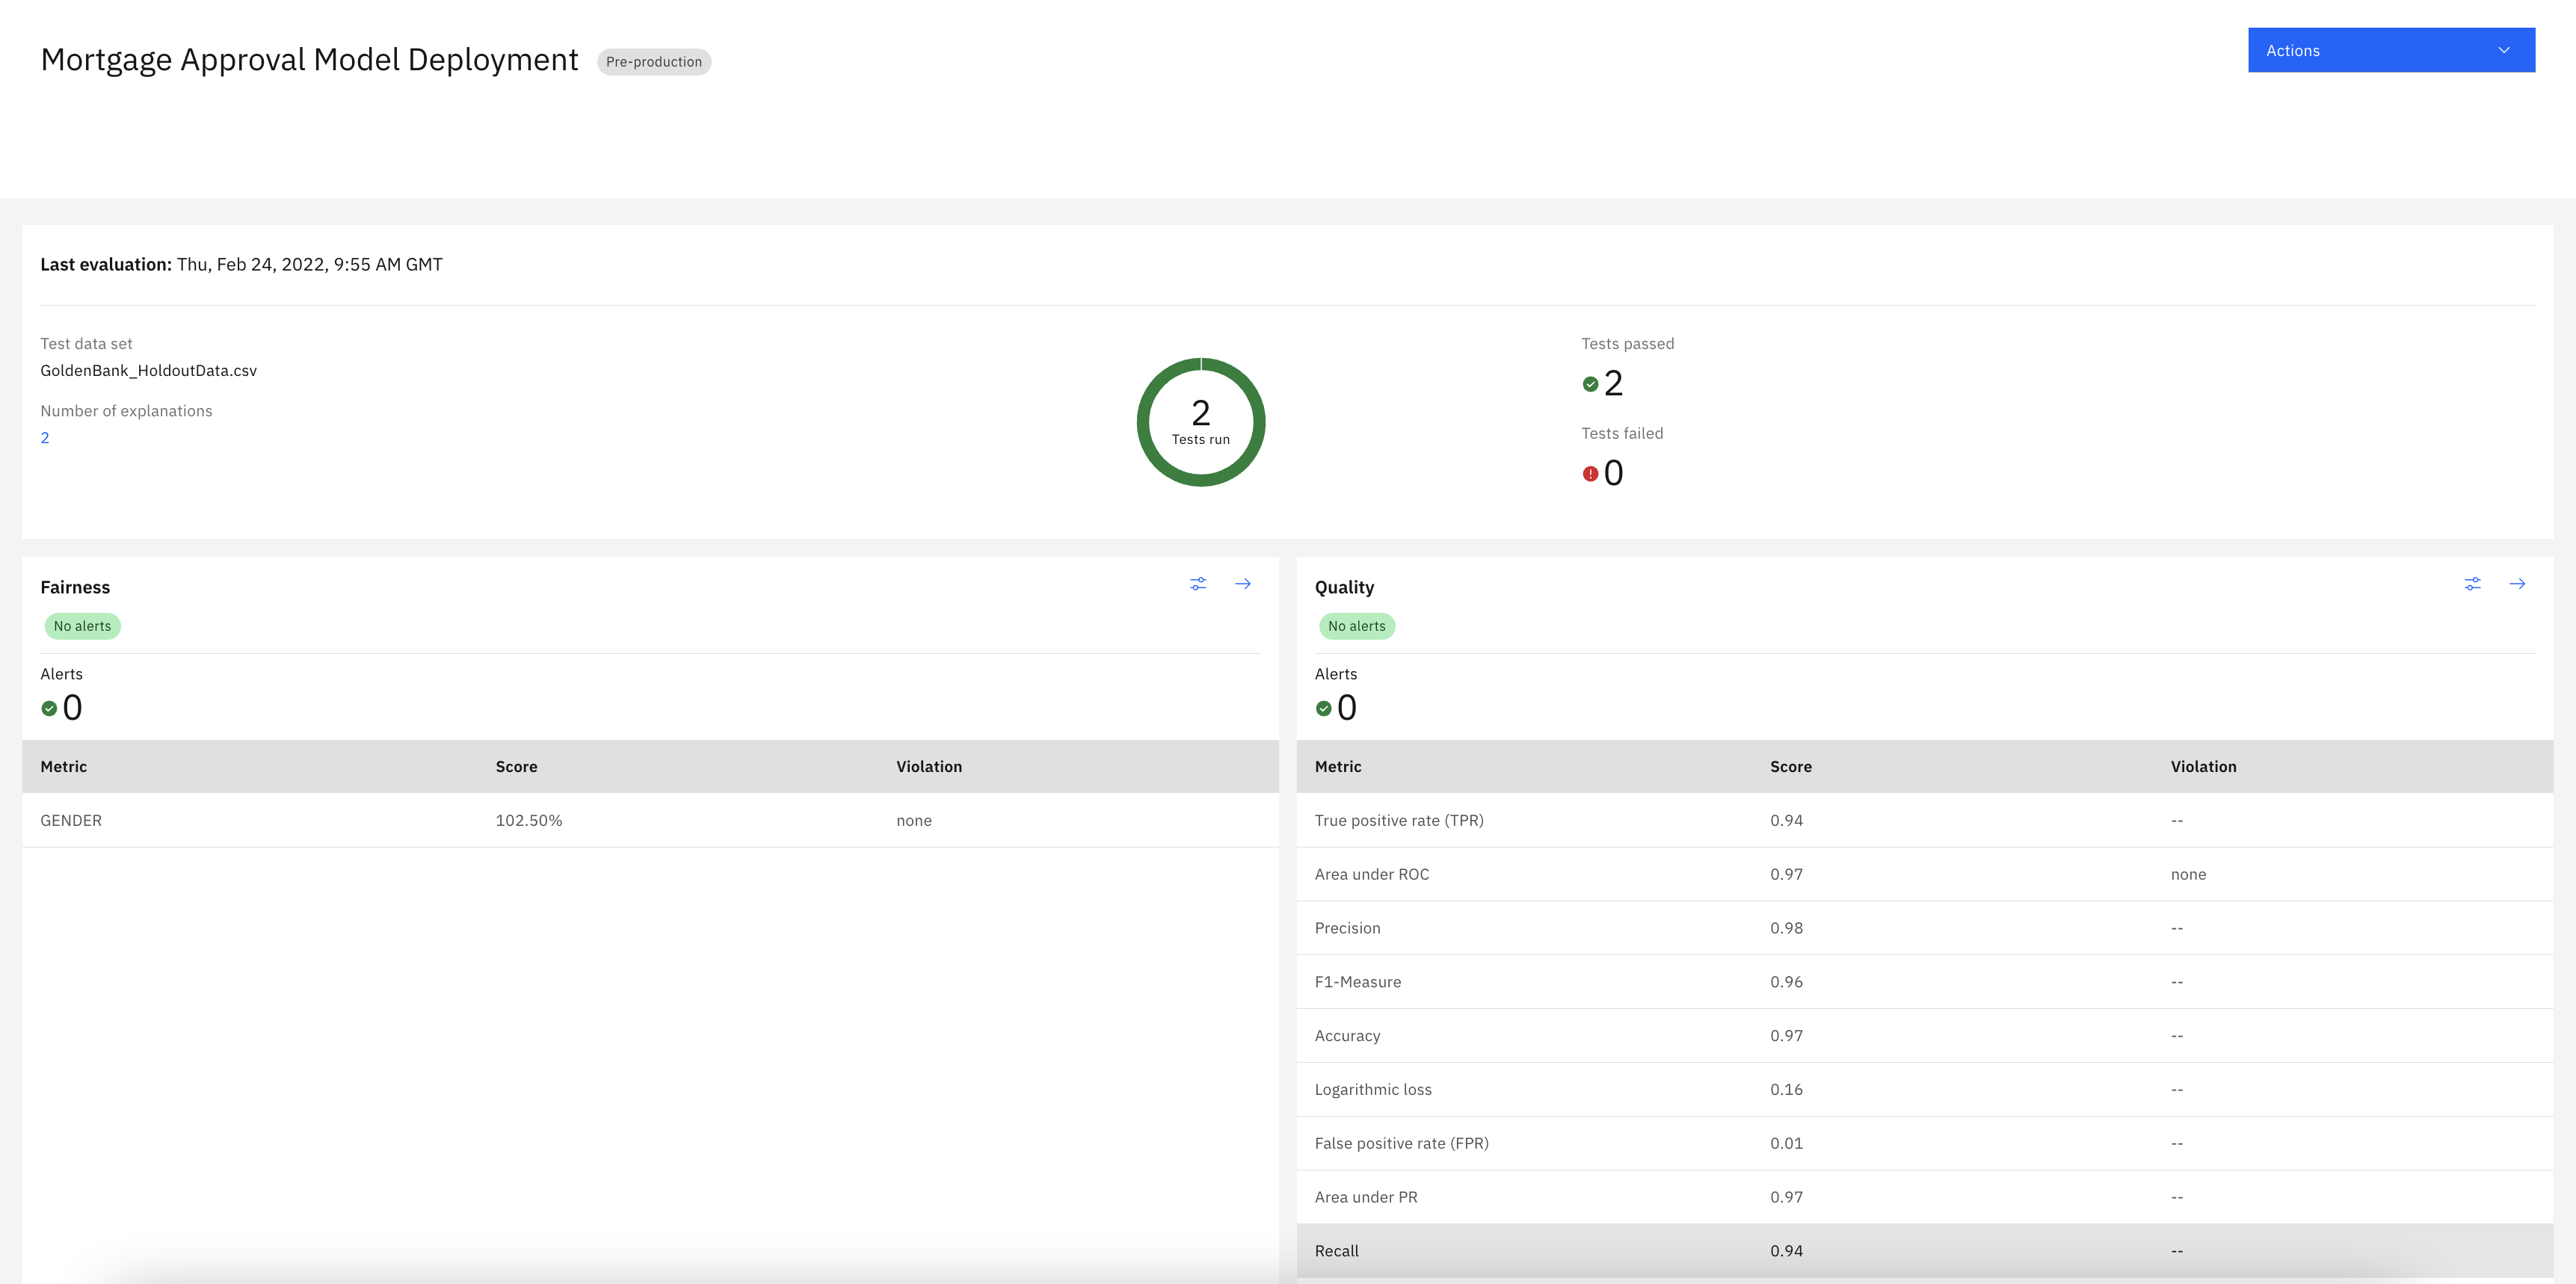
**Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2022. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp. <br>**